In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gzip

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle

import numpy as np

import matplotlib.pyplot as plt

import random


import HMNN

In [2]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 18  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 24  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 24  # Font size of title

Generate the data

In [3]:
def rotation_matrix(angle):

	return np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

In [4]:
angles = np.pi*np.linspace(0, 4, 5)/4

sample_size = 10000
X_raw, y_raw = make_moons(n_samples=5*sample_size, noise=0.1, random_state=42)

X = np.zeros((np.shape(X_raw)[0], 2))
for t in range(5):
	X[t*sample_size:(t*sample_size+sample_size),:] = np.einsum("nk,kj->nj", X_raw[t*sample_size:(t*sample_size+sample_size),:], rotation_matrix(angles[t]))

y = y_raw

In [5]:
sample_size = 10000
X_raw, y_raw = make_moons(n_samples=5*sample_size, noise=0.1, random_state=42)

X_val = np.zeros((np.shape(X_raw)[0], 2))
for t in range(5):
	X_val[t*sample_size:(t*sample_size+sample_size),:] = np.einsum("nk,kj->nj", X_raw[t*sample_size:(t*sample_size+sample_size),:], rotation_matrix(angles[t]))

y_val = y_raw

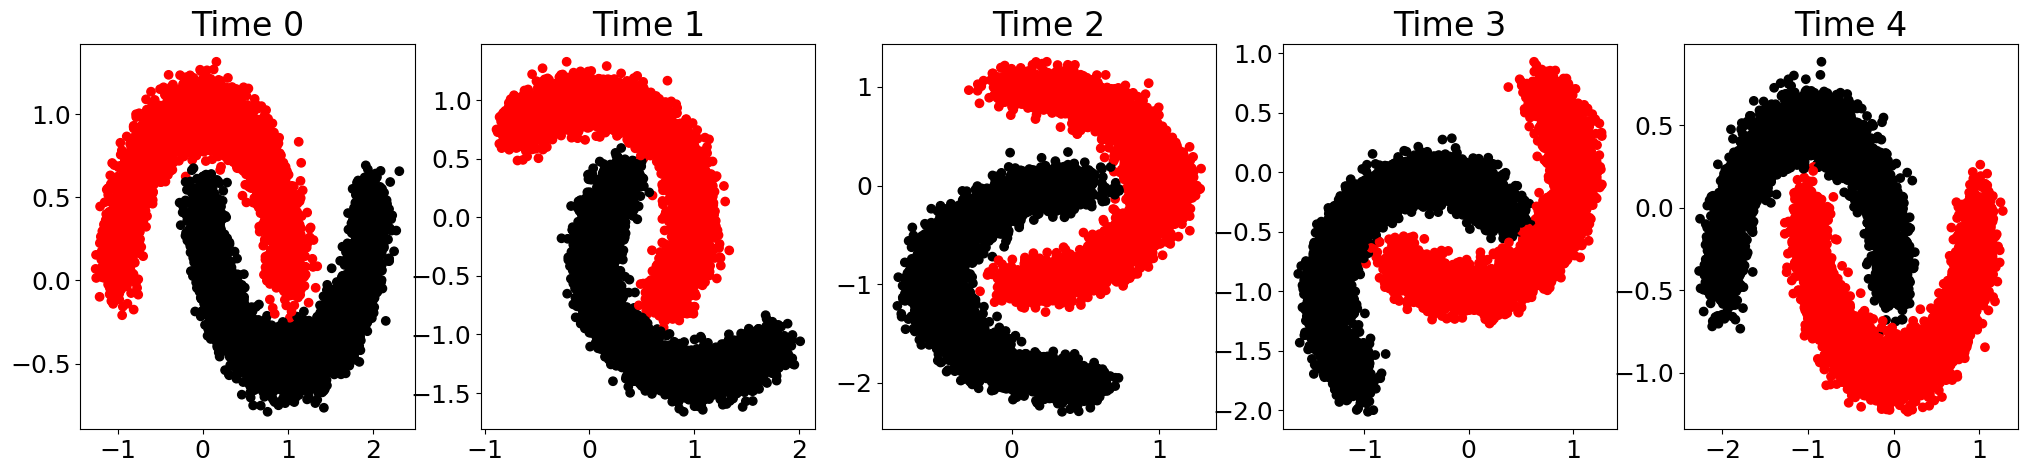

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for t in range(5):

	ax[t].scatter(X[t*sample_size:(t*sample_size+sample_size),0], X[t*sample_size:(t*sample_size+sample_size),1], c = np.array(["red", "black"])[y[t*sample_size:(t*sample_size+sample_size)]])
	# ax[t].set_xlabel("x")

	ax[t].set_title("Time "+str(t))

	# if t==0:
	# 	ax[t].set_ylabel("y")
	# ax[1,t].scatter(X_val[t*sample_size:(t*sample_size+sample_size),0], X_val[t*sample_size:(t*sample_size+sample_size),1], c = y_val[t*sample_size:(t*sample_size+sample_size)])

	
plt.savefig('moonsep_data.png', dpi=100)

In [7]:
# The minibatch size
minibatch_size = 256
# The number of epochs

epocs          = 100 
# This parameter if use to retrain on part of the previous data. 
# If sliding = sample_size then we move to a new set of data.
sliding = sample_size
# Number of Sequential training we want to do minus 1
T = 5

###########################################################
# Set the network structure
# Depth
L = 4
# Structure of the hidden units
architecture = np.array([2, 50, 50, 2])

# Kernel parameter of the HMNN
alpha_k = 0.5
sigma_k = np.exp(-2)
c       = np.exp(5)
pi      = 0.5

# Mixture weight for the variational dropconnect
p       = 0.75

# Learning rate
lr_c = 1e-3

# Size of the Monte Carlo sample
mc_c = 1

In [8]:
%run -i HMNN.py

In [9]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss(reduction = 'sum')


HMMNET = torchHHMnet(architecture, alpha_k, sigma_k, c, pi, p, loss_function, sample_size, minibatch_size, epocs, T, sliding, workers = 4)

HMMNET.forward_pass(X, y, X_val, y_val, lr_c, mc_c)

Time  1
Epoch  1
Prior score  72.54648748053752  and Data score  131.20985011137913
Performance on the validation set  0.84
Epoch  2
Prior score  72.26337297859163  and Data score  87.18781004075926
Performance on the validation set  0.8832
Epoch  3
Prior score  72.1490053032037  and Data score  75.79662994178928
Performance on the validation set  0.897
Epoch  4
Prior score  71.90778735477657  and Data score  72.73472225288921
Performance on the validation set  0.9004
Epoch  5
Prior score  71.4503352457328  and Data score  66.45866133987376
Performance on the validation set  0.8965
Epoch  6
Prior score  71.4663129030961  and Data score  64.03850328534928
Performance on the validation set  0.9153
Epoch  7
Prior score  71.5031625253055  and Data score  60.801746863363874
Performance on the validation set  0.9242
Epoch  8
Prior score  70.92675165891299  and Data score  56.40447692155263
Performance on the validation set  0.9364
Epoch  9
Prior score  71.10830435403074  and Data score  58.1

In [10]:
grid_size = 50
x_grid = np.linspace(-2, 2, grid_size)
y_grid = np.linspace(-2, 2, grid_size)

x_grid, y_grid = np.meshgrid(x_grid, y_grid)

x_1 = np.reshape(x_grid, (grid_size*grid_size))
x_2 = np.reshape(y_grid, (grid_size*grid_size))

X_test = np.stack((x_1, x_2), axis = -1)

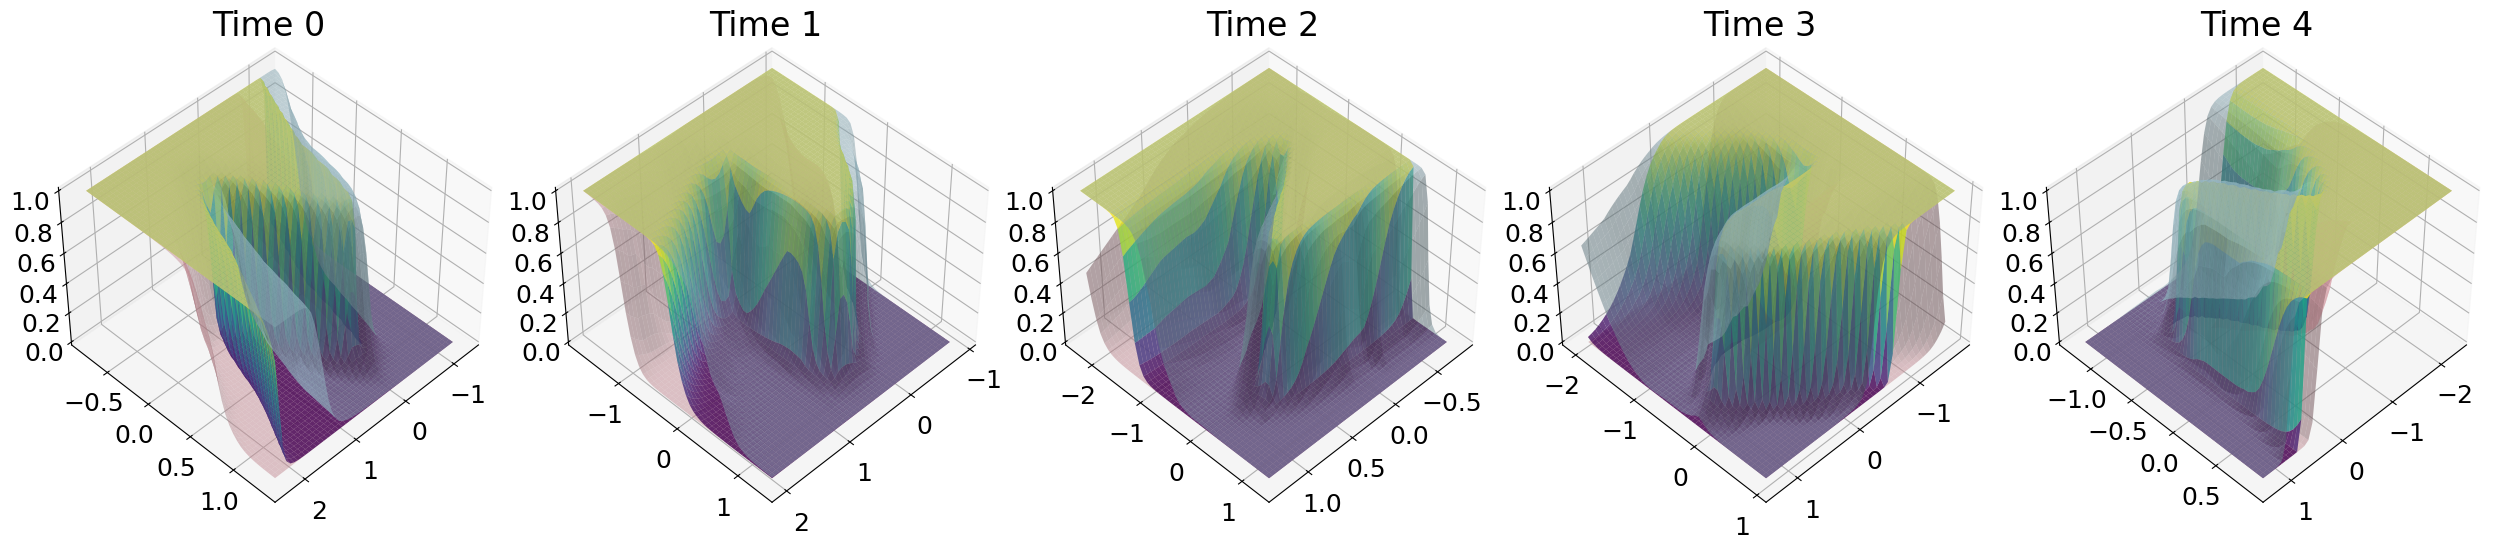

<Figure size 640x480 with 0 Axes>

In [14]:
# Create the figure and 3D axis
fig, axes = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': '3d'})


for i, ax in enumerate(axes):
	t=i

	x_sample = X[t*sample_size:(t*sample_size+sample_size),0]
	y_sample = X[t*sample_size:(t*sample_size+sample_size),1]

	grid_size = 50
	x_grid = np.linspace(np.min(x_sample), np.max(x_sample), grid_size)
	y_grid = np.linspace(np.min(y_sample), np.max(y_sample), grid_size)

	x_grid, y_grid = np.meshgrid(x_grid, y_grid)

	x_1 = np.reshape(x_grid, (grid_size*grid_size))
	x_2 = np.reshape(y_grid, (grid_size*grid_size))

	X_test = np.stack((x_1, x_2), axis = -1)

	perf_sample_list = []
	for s in range(50):
		output = HMMNET.model_list[t+1].forward( torch.tensor(X_test, dtype = torch.float64 ) )
		output_softmax   = F.softmax(output, dim=1)
		perf_sample = np.reshape(output_softmax[:,1].detach().numpy(), (grid_size, grid_size))
		perf_sample_list.append(perf_sample)

	Z_quantiles = np.quantile(np.stack(perf_sample_list, axis = -1), (0.025, 0.975), axis = -1)
	Z_upper = Z_quantiles[1,...]
	Z_lower = Z_quantiles[0,...]

	output = HMMNET.model_list[t+1].performance( torch.tensor(X_test, dtype = torch.float64 ) )
	output_softmax   = F.softmax(output, dim=1)
	Z = np.reshape(output_softmax[:,1].detach().numpy(), (grid_size, grid_size))

	# Plot the main surface
	surf = ax.plot_surface(x_grid, y_grid, Z, cmap='viridis', alpha=0.8, label="Main Surface")

	# Plot the confidence bands (upper and lower surfaces)
	ax.plot_surface(x_grid, y_grid, Z_upper, color='lightblue', alpha=0.5, label="Upper Confidence Band")
	ax.plot_surface(x_grid, y_grid, Z_lower, color='lightpink', alpha=0.5, label="Lower Confidence Band")

	ax.view_init(elev=45, azim=45)

	ax.set_title("Time "+str(t))
	# ax.set_xlabel(r'x')
	# ax.set_ylabel(r'y')
	# ax.set_zlabel('prob.', labelpad=5, rotation=0)

	# if i ==0:
	# 	ax.set_zlabel(r'prob')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


plt.savefig('moonsep_surface.png', dpi=100)

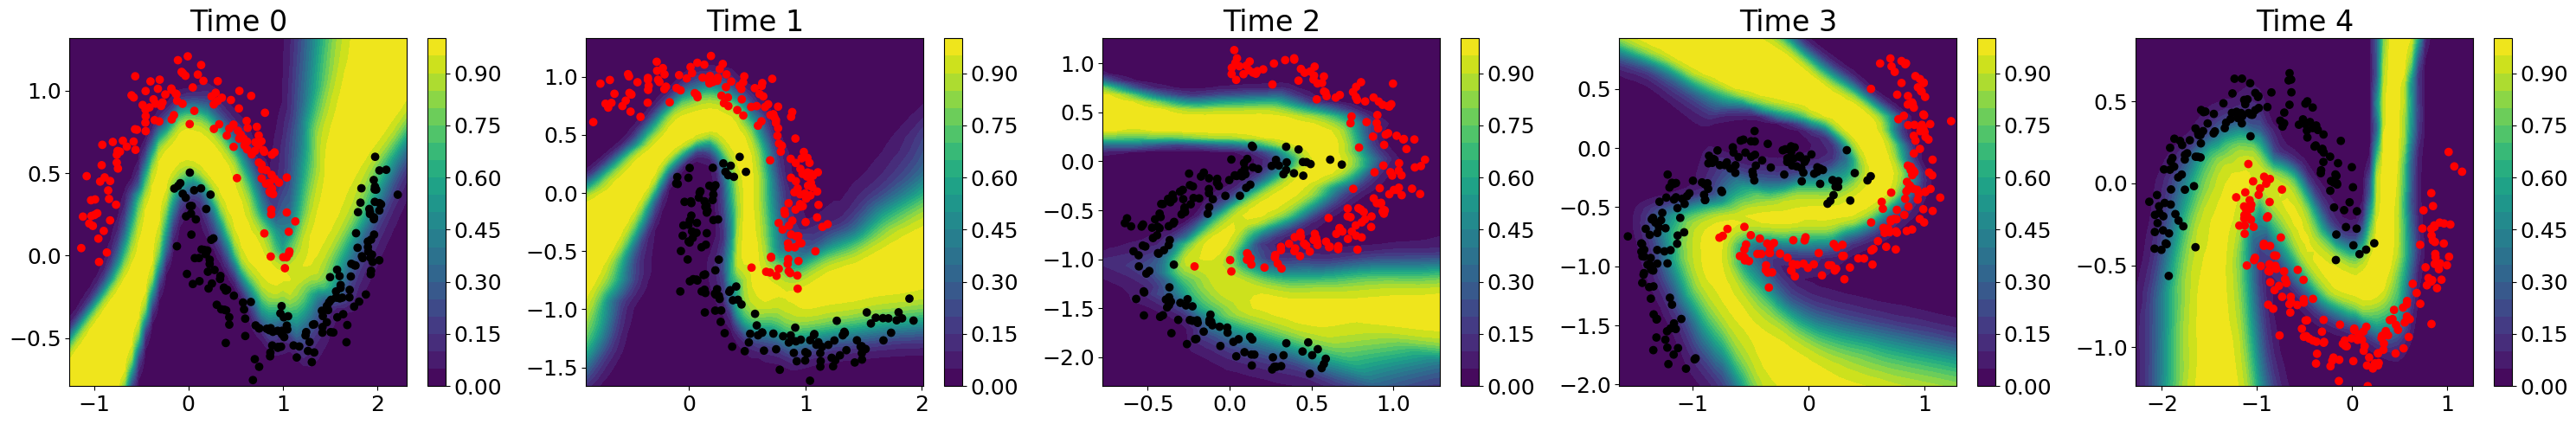

<Figure size 640x480 with 0 Axes>

In [15]:
# Create the figure and 3D axis
fig, axes = plt.subplots(1, 5, figsize=(30, 5))


for i, ax in enumerate(axes):
	t=i

	x_sample = X[t*sample_size:(t*sample_size+sample_size),0]
	y_sample = X[t*sample_size:(t*sample_size+sample_size),1]
	label_sample = y[t*sample_size:(t*sample_size+sample_size)]

	grid_size = 50
	x_grid = np.linspace(np.min(x_sample), np.max(x_sample), grid_size)
	y_grid = np.linspace(np.min(y_sample), np.max(y_sample), grid_size)

	x_grid, y_grid = np.meshgrid(x_grid, y_grid)

	x_1 = np.reshape(x_grid, (grid_size*grid_size))
	x_2 = np.reshape(y_grid, (grid_size*grid_size))

	X_test = np.stack((x_1, x_2), axis = -1)

	perf_sample_list = []
	for s in range(50):
		output = HMMNET.model_list[t+1].forward( torch.tensor(X_test, dtype = torch.float64 ) )
		output_softmax   = F.softmax(output, dim=1)
		perf_sample = np.reshape(output_softmax[:,1].detach().numpy(), (grid_size, grid_size))
		perf_sample_list.append(perf_sample)

	Z_quantiles = np.quantile(np.stack(perf_sample_list, axis = -1), (0.025, 0.975), axis = -1)
	Z_upper = Z_quantiles[1,...]
	Z_lower = Z_quantiles[0,...]

	# Filled contour plot
	contour = ax.contourf(x_grid, y_grid, Z_upper -Z_lower, levels=20, cmap='viridis')  # 'viridis' colormap
	plt.colorbar(contour)  # Add a color bar
	ax.scatter(x_sample[:300], y_sample[:300], c = np.array(["red", "black"])[label_sample[:300]])

	# ax.set_xlabel("x")
	ax.set_title("Time "+str(t))
	
	# if i ==0:
	# 	ax.set_ylabel(r'y')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

plt.savefig('moonsep_ci.png', dpi=100)
